<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>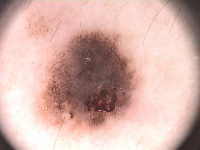</td><td>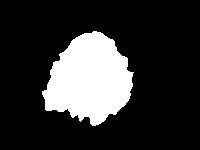</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=084fa9d0-0da2-4405-9a88-ee056c244c63
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 100MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'C:\projects\Python\dl\DataBases\PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
X[0].shape

(256, 256, 3)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

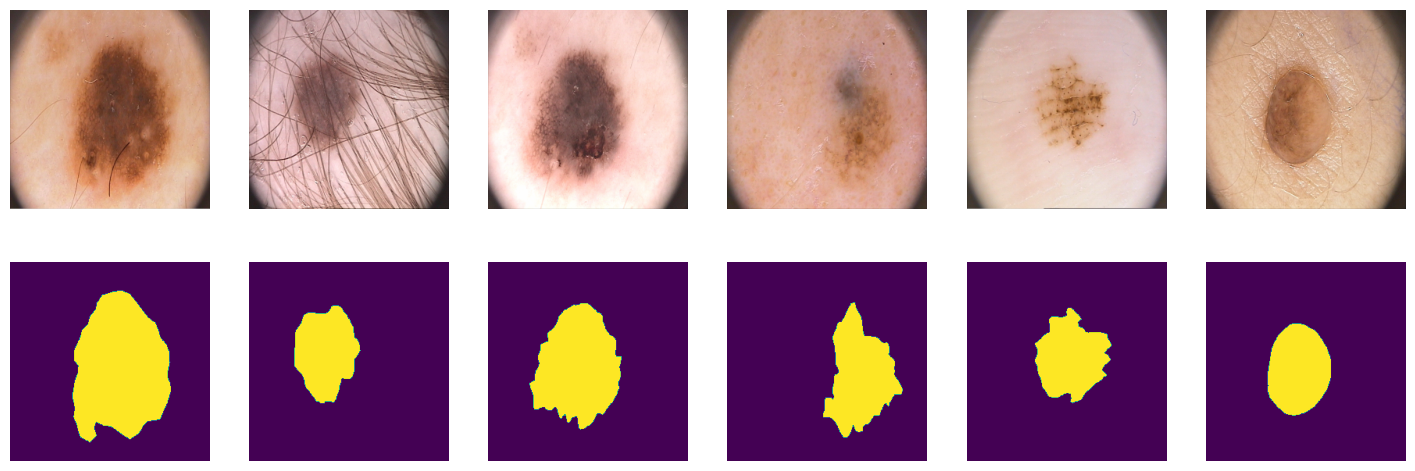

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [13]:
X[tr].shape

(100, 256, 256, 3)

In [14]:
np.rollaxis(X[tr], 3, 1).shape

(100, 3, 256, 256)

In [15]:
np.moveaxis(X[tr], 3, 1).shape

(100, 3, 256, 256)

In [16]:
Y[tr, np.newaxis].shape

(100, 1, 256, 256)

In [17]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),  # = np.moveaxis()
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:



<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [23]:
!pip install torchmetrics

^C


In [41]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**
заранее прошу прощения за вырвиглазное оформление)

x - логит нейронки
z - лейбл исходя из датасета

сигма = 1 / (1 + exp(-x))

  z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
= z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
= z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))
= (1 - z) * x + log(1 + exp(-x))
= x - x * z + log(1 + exp(-x))

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [220]:
import torch.nn.functional as F
import torch.nn as nn

In [221]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [222]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return -torch.sum(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [223]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.742016315460205
BCE loss честно посчитанный = 4.742016315460205
BCE loss from torch bce_torch = 4.742016315460205
BCE loss from torch with logits bce_torch = 4.742016315460205


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [224]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [225]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.297369956970215
BCE loss честно посчитанный = 13.297369003295898
BCE loss from torch bce_torch = 13.297369003295898
BCE loss from torch with logits bce_torch = 13.297369956970215


In [226]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [47]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 6.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 4.67MB/s]
Download completed


In [19]:
path_to_dummy_samples = 'for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22684\1347377685.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_sample

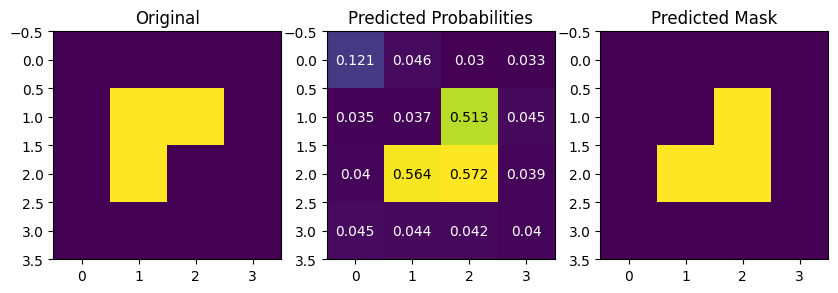

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [229]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

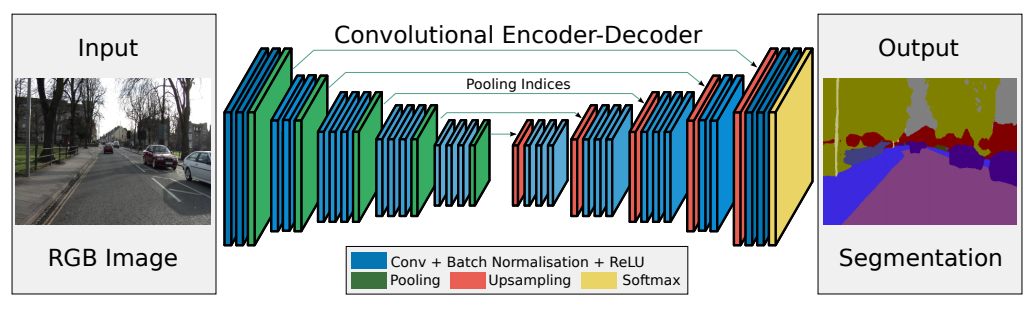

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [2]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        ''' encoder (VGG-16 architecture) '''
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)

        # First block
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        # Second block
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        # Third block
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        # Fourth block
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        # Fifth block
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        
        ''' bottleneck '''
        self.bottleneck = nn.Conv2d(512, 512, kernel_size=1)

        ''' decoder (upsampling) '''
        self.unpool = nn.MaxUnpool2d(2, stride=2)

        # Fifth block
        self.dec5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        # Fourth block
        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        # Third block
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        # Second block
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

        # First block
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )


    def forward(self, x):
        # encoder
        x = self.enc1(x)
        x, ind1 = self.pool(x)
        size1 = x.shape

        x = self.enc2(x)
        x, ind2 = self.pool(x)
        size2 = x.shape

        x = self.enc3(x)
        x, ind3 = self.pool(x)
        size3 = x.shape

        x = self.enc4(x)
        x, ind4 = self.pool(x)
        size4 = x.shape

        x = self.enc5(x)
        x, ind5 = self.pool(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder
        x = self.unpool(x, ind5, output_size=size4)
        x = self.dec5(x)

        x = self.unpool(x, ind4, output_size=size3)
        x = self.dec4(x)

        x = self.unpool(x, ind3, output_size=size2)
        x = self.dec3(x)

        x = self.unpool(x, ind2, output_size=size1)
        x = self.dec2(x)

        x = self.unpool(x, ind1)
        output = self.dec1(x)

        return output # no activation

In [ ]:
segnet_model = SegNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(segnet_model.parameters(), lr=3e-3)

In [358]:
from torchsummary import summary
a = summary(segnet_model, input_size=(3, 256, 256))

Layer (type:depth-idx)                   Param #
├─MaxPool2d: 1-1                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,080
|    └─BatchNorm2d: 2-17                

## Тренировка [1 балл]

Напишите функцию для обучения модели.

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [44]:
import torch
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import warnings

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, test_loader,
                 epochs=100, patience=5, scheduler=None, callbacks=None, average='binary',
                 device='cuda', mode='classification', jacard=None):
        self._model = model
        self._criterion = criterion
        self._optimizer = optimizer
        self._train_loader = train_loader
        self._test_loader = test_loader
        self._epochs = epochs
        self._scheduler = scheduler
        self._patience = patience
        self._device = device
        self._mode = mode

        # История метрик
        if mode == 'classification':
            self._main_metric = 'accuracies'
            self._history = {'train_losses': [], 'valid_losses': [], 'train_accuracies': [], 'valid_accuracies': []}
        elif mode == 'segmentation':
            assert jacard is not None, "The 'jacard' parameter is neccessary to be given with mode 'segmentation'"
            self._iou_score = jacard
            self._main_metric = 'iou'
            self._history = {'train_losses': [], 'valid_losses': [], 'train_iou': [], 'valid_iou': []}            
        if callbacks is not None:
            self._history.update({'valid_' + call.__name__: [] for call in callbacks})
            self._history.update({'train_' + call.__name__: [] for call in callbacks})

        self._callbacks = callbacks
        self._average = average
        self._best_loss = float('inf')
        self._best_acc = 0

    @property
    def history(self):
        return self._history

    @property
    def model(self):
        return self._model

    @property
    def best_loss(self):
        return self._best_loss

    @property
    def best_acc(self):
        return self._best_acc

    @property
    def epochs(self):
        return self._epochs

    def train_model(self):
        self._model.to(self._device)
        epochs_without_improvement = 0

        epochs = 0

        for epoch in range(self._epochs):
            epochs += 1
            start_time = time.time()

            if self._callbacks is not None:
                for call in self._callbacks:
                    self._history[f'train_{call.__name__}'].append(0)
                    self._history[f'valid_{call.__name__}'].append(0)


            train_loss, train_accuracy = self._train_one_epoch(epoch)
            valid_loss, valid_accuracy = self._validate_one_epoch()

            self._history['train_losses'].append(train_loss)
            self._history['valid_losses'].append(valid_loss)
            self._history['train_' + self._main_metric].append(train_accuracy)
            self._history['valid_' + self._main_metric].append(valid_accuracy)

            for call in self._callbacks or []:
                self._history['train_' + call.__name__][-1] /= len(self._train_loader)
                self._history['valid_' + call.__name__][-1] /= len(self._test_loader)

            if valid_loss < self._best_loss:
                self._best_loss = valid_loss
                self._best_acc = valid_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= self._patience:
                print(f'\nEarly stopping triggered after {epoch + 1} epochs')
                break

            if self._scheduler:
                try:
                    self._scheduler.step()
                except Exception as e:
                    print(f'Error running scheduler: {e}')

            epoch_time = time.time() - start_time
            self._print_epoch_summary(epoch, epoch_time)
        self._epochs = epochs

    def _train_one_epoch(self, epoch):
        self._model.train()
        running_loss = 0.0
        correct, total = 0, 0
        iou = 0.0

        pbar = tqdm(self._train_loader, desc=f'Training Epoch {epoch + 1}/{self._epochs}', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(self._device), labels.to(self._device)
            self._optimizer.zero_grad()

            outputs = self._model(inputs)
            loss = self._criterion(outputs, labels)
            loss.backward()
            self._optimizer.step()
            with torch.no_grad():

                running_loss += loss.item()
                total += labels.size(0)
                current_loss = running_loss / (total / labels.size(0))

                _, predicted = torch.max(outputs, 1)
                if self._mode == 'classification':
                    correct += (predicted == labels).sum().item()

                    current_accuracy = correct / total
                    mes = f'Training Epoch {epoch + 1}/{self._epochs} - Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}'
                elif self._mode == 'segmentation':
                    iou = self._iou_score(outputs, labels).tolist()

                    mes = f'Training Epoch {epoch + 1}/{self._epochs} - Loss: {current_loss:.4f}, IoU: {iou:.4f}'

                # Описание с текущими метриками
                if self._callbacks:
                    for call in self._callbacks:
                        metric = call(predicted.to('cpu').flatten(), labels.to('cpu').flatten(), average=self._average)
                        self._history['train_' + call.__name__][-1] += metric
                        mes += f' {call.__name__.capitalize()}: {metric:.4f}'

                pbar.set_description(mes)

        if self._mode == 'classification':
            return running_loss / len(self._train_loader), correct / total
        elif self._mode == 'segmentation':
            return running_loss / len(self._train_loader), iou

    def _validate_one_epoch(self):
        self._model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            pbar = tqdm(self._test_loader, desc='Validating', leave=False)
            for inputs, labels in pbar:
                inputs, labels = inputs.to(self._device), labels.to(self._device)
                outputs = self._model(inputs)
                loss = self._criterion(outputs, labels)

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                if self._mode == 'classification':
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                elif self._mode == 'segmentation':
                    iou = self._iou_score(outputs, labels).tolist()

                for call in self._callbacks or []:
                    metric = call(predicted.to('cpu').flatten(), labels.to('cpu').flatten(), average=self._average)
                    self._history['valid_' + call.__name__][-1] += metric

        if self._mode == 'classification':
            return running_loss / len(self._test_loader), correct / total
        elif self._mode == 'segmentation':
            return running_loss / len(self._train_loader), iou

    def _print_epoch_summary(self, epoch, epoch_time):
        display = f'Epoch {epoch + 1}/{self._epochs} -'
            
        for name, metric in self._history.items():
            if name.startswith('train'):
                display += f" {' '.join(i.capitalize() for i in name.split('_'))}: {round(metric[-1], 3)}, "
                display += f" {' '.join(i.capitalize() for i in ['valid'] + name.split('_')[1:])}: {round(self._history['_'.join(['valid'] + name.split('_')[1:])][-1], 3)}, "
        display = f'{display[:-2]} - Time: {epoch_time:.2f}s'

        print(display)

    def plot_metrics(self):
        fig, axes = plt.subplots(1, len(list(self._history.keys())) // 2, 
                                 figsize=(5 * len(list(self._history.keys())) // 2, 2 * len(self._callbacks) if self._callbacks is not None else 4))

        epochs = range(1, self._epochs+1)
        if self._mode == 'classification':
            default_metrics = ['losses', 'accuracies']
        elif self._mode == 'segmentation':
            default_metrics = ['losses', 'iou']
        for ax, call in zip(axes, default_metrics + self._callbacks if self._callbacks is not None else default_metrics):
            name = call.__name__ if call not in default_metrics else call
            train_metric = self._history[f'train_{name}']
            valid_metric = self._history[f'valid_{name}']
            ax.plot(epochs, train_metric, label=f'train', color='blue')
            ax.plot(epochs, valid_metric, label=f'valid', color='orange')
            ax.set_title(name)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Value')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

In [45]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [362]:
trainer = Trainer(model=segnet_model,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=50,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 0.535,  Valid Losses: 26.799,  Train Iou: 0.436,  Valid Iou: 0.002 - Time: 4.00s


Epoch 2/50 - Train Losses: 0.37,  Valid Losses: 0.514,  Train Iou: 0.732,  Valid Iou: 0.459 - Time: 3.87s


Epoch 3/50 - Train Losses: 0.301,  Valid Losses: 0.182,  Train Iou: 0.782,  Valid Iou: 0.545 - Time: 3.76s


Epoch 4/50 - Train Losses: 0.277,  Valid Losses: 0.248,  Train Iou: 0.737,  Valid Iou: 0.764 - Time: 3.76s


Epoch 5/50 - Train Losses: 0.26,  Valid Losses: 0.227,  Train Iou: 0.541,  Valid Iou: 0.287 - Time: 3.76s


Epoch 6/50 - Train Losses: 0.268,  Valid Losses: 0.233,  Train Iou: 0.846,  Valid Iou: 0.484 - Time: 3.77s


Epoch 7/50 - Train Losses: 0.257,  Valid Losses: 0.214,  Train Iou: 0.708,  Valid Iou: 0.687 - Time: 3.82s


Epoch 8/50 - Train Losses: 0.253,  Valid Losses: 0.247,  Train Iou: 0.646,  Valid Iou: 0.615 - Time: 3.76s


Epoch 9/50 - Train Losses: 0.269,  Valid Losses: 0.166,  Train Iou: 0.657,  Valid Iou: 0.82 - Time: 3.82s


Epoch 10/50 - Train Losses: 0.248,  Valid Losses: 0.146,  Train Iou: 0.719,  Valid Iou: 0.828 - Time: 3.77s


Epoch 11/50 - Train Losses: 0.251,  Valid Losses: 0.161,  Train Iou: 0.84,  Valid Iou: 0.806 - Time: 3.93s


Epoch 12/50 - Train Losses: 0.227,  Valid Losses: 0.128,  Train Iou: 0.717,  Valid Iou: 0.815 - Time: 3.77s


Epoch 13/50 - Train Losses: 0.202,  Valid Losses: 0.137,  Train Iou: 0.82,  Valid Iou: 0.857 - Time: 3.88s


Epoch 14/50 - Train Losses: 0.212,  Valid Losses: 0.14,  Train Iou: 0.796,  Valid Iou: 0.624 - Time: 3.76s


Epoch 15/50 - Train Losses: 0.216,  Valid Losses: 0.125,  Train Iou: 0.789,  Valid Iou: 0.858 - Time: 3.76s


Epoch 16/50 - Train Losses: 0.185,  Valid Losses: 0.181,  Train Iou: 0.693,  Valid Iou: 0.543 - Time: 3.76s


Epoch 17/50 - Train Losses: 0.208,  Valid Losses: 0.13,  Train Iou: 0.785,  Valid Iou: 0.821 - Time: 3.76s


Epoch 18/50 - Train Losses: 0.188,  Valid Losses: 0.114,  Train Iou: 0.708,  Valid Iou: 0.863 - Time: 3.76s


Epoch 19/50 - Train Losses: 0.219,  Valid Losses: 0.122,  Train Iou: 0.738,  Valid Iou: 0.721 - Time: 3.83s


Epoch 20/50 - Train Losses: 0.21,  Valid Losses: 0.129,  Train Iou: 0.817,  Valid Iou: 0.73 - Time: 3.77s


Epoch 21/50 - Train Losses: 0.195,  Valid Losses: 0.116,  Train Iou: 0.829,  Valid Iou: 0.788 - Time: 3.76s


Epoch 22/50 - Train Losses: 0.199,  Valid Losses: 0.118,  Train Iou: 0.59,  Valid Iou: 0.847 - Time: 3.76s


Epoch 23/50 - Train Losses: 0.189,  Valid Losses: 0.112,  Train Iou: 0.795,  Valid Iou: 0.884 - Time: 3.76s


Epoch 24/50 - Train Losses: 0.181,  Valid Losses: 0.119,  Train Iou: 0.825,  Valid Iou: 0.784 - Time: 3.76s


Epoch 25/50 - Train Losses: 0.181,  Valid Losses: 0.111,  Train Iou: 0.86,  Valid Iou: 0.786 - Time: 3.76s


Epoch 26/50 - Train Losses: 0.19,  Valid Losses: 0.101,  Train Iou: 0.859,  Valid Iou: 0.82 - Time: 3.76s


Epoch 27/50 - Train Losses: 0.166,  Valid Losses: 0.108,  Train Iou: 0.744,  Valid Iou: 0.691 - Time: 3.76s


Epoch 28/50 - Train Losses: 0.17,  Valid Losses: 0.102,  Train Iou: 0.791,  Valid Iou: 0.605 - Time: 3.76s


Epoch 29/50 - Train Losses: 0.181,  Valid Losses: 0.141,  Train Iou: 0.722,  Valid Iou: 0.627 - Time: 3.76s


Epoch 30/50 - Train Losses: 0.15,  Valid Losses: 0.106,  Train Iou: 0.87,  Valid Iou: 0.886 - Time: 3.76s


Epoch 31/50 - Train Losses: 0.183,  Valid Losses: 0.104,  Train Iou: 0.909,  Valid Iou: 0.87 - Time: 3.76s


Epoch 32/50 - Train Losses: 0.169,  Valid Losses: 0.102,  Train Iou: 0.801,  Valid Iou: 0.867 - Time: 3.76s


Epoch 33/50 - Train Losses: 0.161,  Valid Losses: 0.096,  Train Iou: 0.744,  Valid Iou: 0.884 - Time: 3.76s


Epoch 34/50 - Train Losses: 0.188,  Valid Losses: 0.105,  Train Iou: 0.354,  Valid Iou: 0.755 - Time: 3.76s


Epoch 35/50 - Train Losses: 0.174,  Valid Losses: 0.104,  Train Iou: 0.49,  Valid Iou: 0.762 - Time: 3.76s


Epoch 36/50 - Train Losses: 0.172,  Valid Losses: 0.11,  Train Iou: 0.792,  Valid Iou: 0.395 - Time: 3.76s


Epoch 37/50 - Train Losses: 0.145,  Valid Losses: 0.106,  Train Iou: 0.897,  Valid Iou: 0.865 - Time: 3.76s


Epoch 38/50 - Train Losses: 0.156,  Valid Losses: 0.098,  Train Iou: 0.883,  Valid Iou: 0.895 - Time: 3.76s


Epoch 39/50 - Train Losses: 0.159,  Valid Losses: 0.093,  Train Iou: 0.892,  Valid Iou: 0.881 - Time: 3.76s


Epoch 40/50 - Train Losses: 0.165,  Valid Losses: 0.104,  Train Iou: 0.922,  Valid Iou: 0.773 - Time: 3.76s


Epoch 41/50 - Train Losses: 0.161,  Valid Losses: 0.098,  Train Iou: 0.751,  Valid Iou: 0.886 - Time: 3.76s


Epoch 42/50 - Train Losses: 0.155,  Valid Losses: 0.101,  Train Iou: 0.919,  Valid Iou: 0.835 - Time: 3.76s


Epoch 43/50 - Train Losses: 0.158,  Valid Losses: 0.094,  Train Iou: 0.928,  Valid Iou: 0.86 - Time: 3.77s


Epoch 44/50 - Train Losses: 0.146,  Valid Losses: 0.095,  Train Iou: 0.82,  Valid Iou: 0.884 - Time: 3.76s


Epoch 45/50 - Train Losses: 0.198,  Valid Losses: 0.101,  Train Iou: 0.883,  Valid Iou: 0.85 - Time: 3.77s


Epoch 46/50 - Train Losses: 0.153,  Valid Losses: 0.105,  Train Iou: 0.787,  Valid Iou: 0.829 - Time: 3.77s


Epoch 47/50 - Train Losses: 0.144,  Valid Losses: 0.1,  Train Iou: 0.905,  Valid Iou: 0.901 - Time: 3.76s


Epoch 48/50 - Train Losses: 0.17,  Valid Losses: 0.103,  Train Iou: 0.675,  Valid Iou: 0.789 - Time: 3.76s


Epoch 49/50 - Train Losses: 0.159,  Valid Losses: 0.098,  Train Iou: 0.721,  Valid Iou: 0.864 - Time: 3.78s


Epoch 50/50 - Train Losses: 0.172,  Valid Losses: 0.133,  Train Iou: 0.649,  Valid Iou: 0.632 - Time: 3.78s


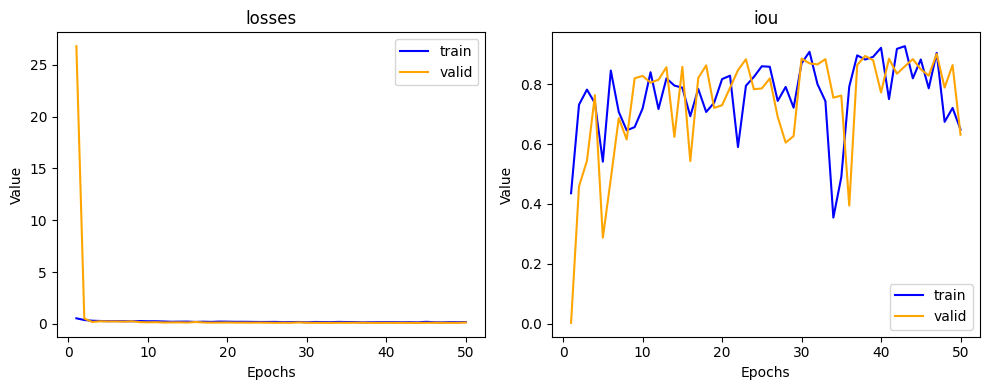

In [363]:
trainer.plot_metrics()

In [364]:
model = trainer.model

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [84]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)


In [366]:
test(model, test_dataloader)

tensor(0.7925, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [25]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    probs = torch.sigmoid(logits)
    mask = (probs > threshold).float()

    tp = torch.sum(mask*labels)
    fp = torch.sum(mask) - tp
    fn = torch.sum(labels) - tp

    eps = 10**-8
    score = (2 * tp + eps) / (2*tp + fp + fn + eps)

    return score

Проверим на корректность функцию dice_score:

In [26]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [27]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [28]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [29]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    probs = torch.sigmoid(logits)
    
    tp = torch.sum(probs*labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp

    eps = 10**-8
    score = (2 * tp + eps) / (2*tp + fp + fn + eps)

    loss = 1 - score
    

    return loss

Проверка на корректность:

In [30]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [31]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [32]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [32]:
import torch
import torch.nn.functional as F

def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):
    # Вычисляем предсказанные вероятности
    p = torch.sigmoid(y_pred) * y_real + (1 - torch.sigmoid(y_pred)) * (1 - y_real)
    # Вычисляем BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    # Вычисляем фокусную лосс
    focal_factor = (1 - p) ** gamma
    loss = torch.sum(focal_factor * bce_loss)

    return loss


Проверка корректности функции:

In [33]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [34]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2)

tensor(3.6161, device='cuda:0')

Поменял на isclose, чтобы прошел assert, тк различия просто буквально в стотысячных незначительны, но не дают пройти проверку

In [35]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').cpu() == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0).cpu()

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [45]:
def tversky_loss(logits, labels, alpha=0.5, beta=0.5, smooth=0, gamma=1.0, eps=1e-8):
    probs = torch.sigmoid(logits)
    tp = torch.sum(probs * labels)
    fp = torch.sum(probs) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8
    tversky_score = (tp + smooth + eps) / (tp + alpha*fp + beta*fn + smooth + eps)
    tversky_loss = (1 - tversky_score)**gamma
    return tversky_loss

In [56]:
from segmentation_models_pytorch.losses import TverskyLoss

tversky_loss_torch = TverskyLoss(alpha=0.5, beta=0.5, mode='binary', log_loss=False)
tversky_loss_torch(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())

tensor(0.5756)

In [47]:
tversky_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())

tensor(0.5756)

In [48]:
dice_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())

tensor(0.5756)

Как можно видеть, лосс считается правильно. Также при alpha, beta = 0.5, лосс совпадает с Dice. Но в целом tversky - обобщение для focal, dice

In [49]:
import numpy as np
alphas, betas = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))

In [50]:
for al, be in zip(alphas, betas):
    for a, b in zip(al, be):
        tversky_loss_torch = TverskyLoss(alpha=a, beta=b, mode='binary', log_loss=False)
        assert np.isclose(tversky_loss_torch(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu()), tversky_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu(), alpha=a, beta=b))

все проверки пройдены, то есть функция написана верно

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



#### Dice

In [89]:
segnet_model_dice = SegNet().to(device)
loss_fn = dice_loss
optimizer = optim.Adam(segnet_model_dice.parameters(), lr=3e-3)

In [90]:
trainer = Trainer(model=segnet_model_dice,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=50,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 0.549,  Valid Losses: 0.218,  Train Iou: 0.47,  Valid Iou: 0.531 - Time: 3.82s


Epoch 2/50 - Train Losses: 0.39,  Valid Losses: 0.238,  Train Iou: 0.487,  Valid Iou: 0.282 - Time: 3.81s


Epoch 3/50 - Train Losses: 0.252,  Valid Losses: 0.108,  Train Iou: 0.566,  Valid Iou: 0.739 - Time: 3.82s


Epoch 4/50 - Train Losses: 0.197,  Valid Losses: 0.11,  Train Iou: 0.666,  Valid Iou: 0.634 - Time: 3.82s


Epoch 5/50 - Train Losses: 0.199,  Valid Losses: 0.102,  Train Iou: 0.546,  Valid Iou: 0.854 - Time: 3.81s


Epoch 6/50 - Train Losses: 0.176,  Valid Losses: 0.091,  Train Iou: 0.487,  Valid Iou: 0.812 - Time: 3.81s


Epoch 7/50 - Train Losses: 0.168,  Valid Losses: 0.098,  Train Iou: 0.85,  Valid Iou: 0.601 - Time: 3.81s


Epoch 8/50 - Train Losses: 0.179,  Valid Losses: 0.069,  Train Iou: 0.582,  Valid Iou: 0.712 - Time: 3.81s


Epoch 9/50 - Train Losses: 0.175,  Valid Losses: 0.099,  Train Iou: 0.676,  Valid Iou: 0.787 - Time: 3.81s


Epoch 10/50 - Train Losses: 0.183,  Valid Losses: 0.079,  Train Iou: 0.53,  Valid Iou: 0.651 - Time: 3.81s


Epoch 11/50 - Train Losses: 0.172,  Valid Losses: 0.101,  Train Iou: 0.734,  Valid Iou: 0.542 - Time: 3.81s


Epoch 12/50 - Train Losses: 0.151,  Valid Losses: 0.139,  Train Iou: 0.685,  Valid Iou: 0.555 - Time: 3.81s


Epoch 13/50 - Train Losses: 0.156,  Valid Losses: 0.066,  Train Iou: 0.833,  Valid Iou: 0.882 - Time: 3.81s


Epoch 14/50 - Train Losses: 0.149,  Valid Losses: 0.075,  Train Iou: 0.749,  Valid Iou: 0.867 - Time: 3.81s


Epoch 15/50 - Train Losses: 0.12,  Valid Losses: 0.073,  Train Iou: 0.829,  Valid Iou: 0.811 - Time: 3.81s


Epoch 16/50 - Train Losses: 0.182,  Valid Losses: 0.075,  Train Iou: 0.463,  Valid Iou: 0.812 - Time: 3.81s


Epoch 17/50 - Train Losses: 0.141,  Valid Losses: 0.079,  Train Iou: 0.811,  Valid Iou: 0.854 - Time: 3.81s


Epoch 18/50 - Train Losses: 0.138,  Valid Losses: 0.079,  Train Iou: 0.827,  Valid Iou: 0.711 - Time: 3.81s


Epoch 19/50 - Train Losses: 0.141,  Valid Losses: 0.072,  Train Iou: 0.784,  Valid Iou: 0.876 - Time: 3.82s


Epoch 20/50 - Train Losses: 0.133,  Valid Losses: 0.095,  Train Iou: 0.857,  Valid Iou: 0.412 - Time: 3.82s


Epoch 21/50 - Train Losses: 0.14,  Valid Losses: 0.072,  Train Iou: 0.569,  Valid Iou: 0.849 - Time: 3.82s


Epoch 22/50 - Train Losses: 0.14,  Valid Losses: 0.081,  Train Iou: 0.659,  Valid Iou: 0.667 - Time: 3.83s


Epoch 23/50 - Train Losses: 0.115,  Valid Losses: 0.074,  Train Iou: 0.808,  Valid Iou: 0.822 - Time: 3.82s


Epoch 24/50 - Train Losses: 0.122,  Valid Losses: 0.085,  Train Iou: 0.892,  Valid Iou: 0.577 - Time: 3.83s


Epoch 25/50 - Train Losses: 0.123,  Valid Losses: 0.072,  Train Iou: 0.856,  Valid Iou: 0.675 - Time: 3.83s


Epoch 26/50 - Train Losses: 0.118,  Valid Losses: 0.066,  Train Iou: 0.731,  Valid Iou: 0.858 - Time: 3.82s


Epoch 27/50 - Train Losses: 0.109,  Valid Losses: 0.08,  Train Iou: 0.871,  Valid Iou: 0.597 - Time: 3.82s


Epoch 28/50 - Train Losses: 0.114,  Valid Losses: 0.065,  Train Iou: 0.886,  Valid Iou: 0.91 - Time: 3.83s


Epoch 29/50 - Train Losses: 0.123,  Valid Losses: 0.079,  Train Iou: 0.628,  Valid Iou: 0.574 - Time: 3.83s


Epoch 30/50 - Train Losses: 0.134,  Valid Losses: 0.068,  Train Iou: 0.306,  Valid Iou: 0.859 - Time: 3.83s


Epoch 31/50 - Train Losses: 0.117,  Valid Losses: 0.064,  Train Iou: 0.817,  Valid Iou: 0.897 - Time: 3.88s


Epoch 32/50 - Train Losses: 0.121,  Valid Losses: 0.055,  Train Iou: 0.793,  Valid Iou: 0.877 - Time: 3.87s


Epoch 33/50 - Train Losses: 0.127,  Valid Losses: 0.076,  Train Iou: 0.65,  Valid Iou: 0.652 - Time: 3.84s


Epoch 34/50 - Train Losses: 0.109,  Valid Losses: 0.069,  Train Iou: 0.894,  Valid Iou: 0.774 - Time: 3.83s


Epoch 35/50 - Train Losses: 0.117,  Valid Losses: 0.057,  Train Iou: 0.769,  Valid Iou: 0.907 - Time: 3.83s


Epoch 36/50 - Train Losses: 0.125,  Valid Losses: 0.066,  Train Iou: 0.886,  Valid Iou: 0.878 - Time: 3.83s


Epoch 37/50 - Train Losses: 0.115,  Valid Losses: 0.057,  Train Iou: 0.61,  Valid Iou: 0.843 - Time: 3.82s


Epoch 38/50 - Train Losses: 0.107,  Valid Losses: 0.057,  Train Iou: 0.743,  Valid Iou: 0.901 - Time: 3.83s


Epoch 39/50 - Train Losses: 0.1,  Valid Losses: 0.072,  Train Iou: 0.834,  Valid Iou: 0.577 - Time: 3.83s


Epoch 40/50 - Train Losses: 0.114,  Valid Losses: 0.058,  Train Iou: 0.849,  Valid Iou: 0.869 - Time: 3.83s


Epoch 41/50 - Train Losses: 0.117,  Valid Losses: 0.059,  Train Iou: 0.871,  Valid Iou: 0.842 - Time: 3.83s


Epoch 42/50 - Train Losses: 0.114,  Valid Losses: 0.059,  Train Iou: 0.476,  Valid Iou: 0.92 - Time: 3.83s


Epoch 43/50 - Train Losses: 0.124,  Valid Losses: 0.055,  Train Iou: 0.879,  Valid Iou: 0.92 - Time: 3.83s


Epoch 44/50 - Train Losses: 0.089,  Valid Losses: 0.056,  Train Iou: 0.933,  Valid Iou: 0.875 - Time: 3.83s


Epoch 45/50 - Train Losses: 0.107,  Valid Losses: 0.056,  Train Iou: 0.811,  Valid Iou: 0.84 - Time: 3.83s


Epoch 46/50 - Train Losses: 0.122,  Valid Losses: 0.067,  Train Iou: 0.676,  Valid Iou: 0.663 - Time: 3.83s


Epoch 47/50 - Train Losses: 0.116,  Valid Losses: 0.057,  Train Iou: 0.711,  Valid Iou: 0.909 - Time: 3.83s


Epoch 48/50 - Train Losses: 0.1,  Valid Losses: 0.055,  Train Iou: 0.788,  Valid Iou: 0.931 - Time: 3.83s


Epoch 49/50 - Train Losses: 0.1,  Valid Losses: 0.073,  Train Iou: 0.856,  Valid Iou: 0.527 - Time: 3.83s


Epoch 50/50 - Train Losses: 0.099,  Valid Losses: 0.058,  Train Iou: 0.842,  Valid Iou: 0.803 - Time: 3.83s


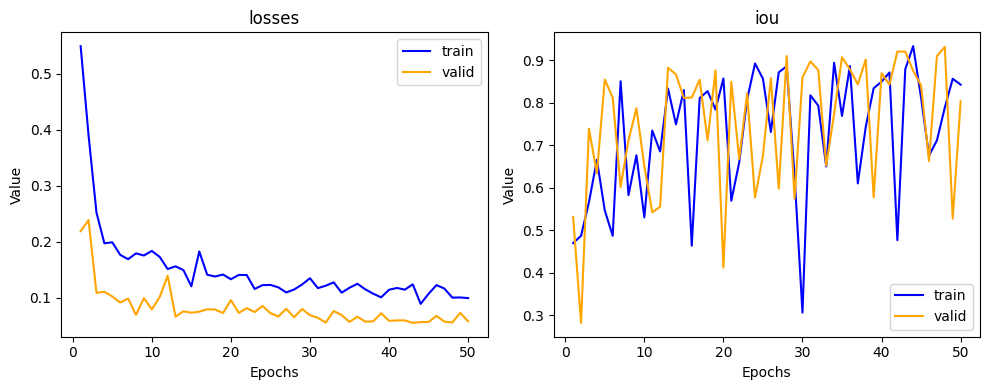

In [91]:
trainer.plot_metrics()

In [92]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)

In [93]:
segnet_model_dice = trainer.model

In [94]:
test(segnet_model_dice, test_dataloader)

tensor(0.7580, device='cuda:0')

#### Focal

In [95]:
segnet_model_focal = SegNet().to(device)
loss_fn = focal_loss
optimizer = optim.Adam(segnet_model_focal.parameters(), lr=3e-3)

In [96]:
trainer = Trainer(model=segnet_model_focal,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=50,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 76567.432,  Valid Losses: 179264300.308,  Train Iou: 0.689,  Valid Iou: 0.0 - Time: 3.84s


Epoch 2/50 - Train Losses: 43407.269,  Valid Losses: 373389.214,  Train Iou: 0.476,  Valid Iou: 0.856 - Time: 3.83s


Epoch 3/50 - Train Losses: 32148.605,  Valid Losses: 40730.078,  Train Iou: 0.822,  Valid Iou: 0.737 - Time: 3.83s


Epoch 4/50 - Train Losses: 38796.087,  Valid Losses: 24715.508,  Train Iou: 0.758,  Valid Iou: 0.831 - Time: 3.83s


Epoch 5/50 - Train Losses: 41661.52,  Valid Losses: 33757.115,  Train Iou: 0.801,  Valid Iou: 0.545 - Time: 3.82s


Epoch 6/50 - Train Losses: 48858.804,  Valid Losses: 41250.834,  Train Iou: 0.472,  Valid Iou: 0.368 - Time: 3.83s


Epoch 7/50 - Train Losses: 41222.89,  Valid Losses: 51165.435,  Train Iou: 0.596,  Valid Iou: 0.401 - Time: 3.83s


Epoch 8/50 - Train Losses: 32298.808,  Valid Losses: 23733.948,  Train Iou: 0.659,  Valid Iou: 0.653 - Time: 3.83s


Epoch 9/50 - Train Losses: 34936.991,  Valid Losses: 19933.079,  Train Iou: 0.821,  Valid Iou: 0.343 - Time: 3.83s


Epoch 10/50 - Train Losses: 33432.964,  Valid Losses: 19541.918,  Train Iou: 0.497,  Valid Iou: 0.746 - Time: 3.82s


Epoch 11/50 - Train Losses: 32109.523,  Valid Losses: 23456.72,  Train Iou: 0.469,  Valid Iou: 0.761 - Time: 3.83s


Epoch 12/50 - Train Losses: 27318.239,  Valid Losses: 19271.583,  Train Iou: 0.734,  Valid Iou: 0.835 - Time: 3.83s


Epoch 13/50 - Train Losses: 27062.205,  Valid Losses: 21154.248,  Train Iou: 0.743,  Valid Iou: 0.345 - Time: 3.83s


Epoch 14/50 - Train Losses: 26397.792,  Valid Losses: 20975.291,  Train Iou: 0.699,  Valid Iou: 0.829 - Time: 3.83s


Epoch 15/50 - Train Losses: 25388.33,  Valid Losses: 21357.153,  Train Iou: 0.783,  Valid Iou: 0.677 - Time: 3.83s


Epoch 16/50 - Train Losses: 25707.146,  Valid Losses: 19423.703,  Train Iou: 0.733,  Valid Iou: 0.936 - Time: 3.83s


Epoch 17/50 - Train Losses: 25267.448,  Valid Losses: 22369.088,  Train Iou: 0.743,  Valid Iou: 0.832 - Time: 3.83s


Epoch 18/50 - Train Losses: 24952.241,  Valid Losses: 18272.3,  Train Iou: 0.807,  Valid Iou: 0.567 - Time: 3.83s


Epoch 19/50 - Train Losses: 23981.358,  Valid Losses: 18754.96,  Train Iou: 0.718,  Valid Iou: 0.68 - Time: 3.82s


Epoch 20/50 - Train Losses: 22621.873,  Valid Losses: 16474.899,  Train Iou: 0.821,  Valid Iou: 0.421 - Time: 3.83s


Epoch 21/50 - Train Losses: 25106.117,  Valid Losses: 16255.799,  Train Iou: 0.74,  Valid Iou: 0.669 - Time: 3.83s


Epoch 22/50 - Train Losses: 22156.382,  Valid Losses: 17540.285,  Train Iou: 0.647,  Valid Iou: 0.85 - Time: 3.82s


Epoch 23/50 - Train Losses: 21897.648,  Valid Losses: 18647.496,  Train Iou: 0.519,  Valid Iou: 0.828 - Time: 3.83s


Epoch 24/50 - Train Losses: 21459.226,  Valid Losses: 17072.611,  Train Iou: 0.815,  Valid Iou: 0.826 - Time: 3.83s


Epoch 25/50 - Train Losses: 24649.041,  Valid Losses: 19583.468,  Train Iou: 0.853,  Valid Iou: 0.909 - Time: 3.83s


Epoch 26/50 - Train Losses: 22418.631,  Valid Losses: 19398.572,  Train Iou: 0.617,  Valid Iou: 0.836 - Time: 3.83s


Epoch 27/50 - Train Losses: 20337.295,  Valid Losses: 16693.693,  Train Iou: 0.827,  Valid Iou: 0.892 - Time: 3.83s


Epoch 28/50 - Train Losses: 20382.101,  Valid Losses: 17548.723,  Train Iou: 0.855,  Valid Iou: 0.9 - Time: 3.83s


Epoch 29/50 - Train Losses: 19914.752,  Valid Losses: 16319.576,  Train Iou: 0.804,  Valid Iou: 0.878 - Time: 3.83s


Epoch 30/50 - Train Losses: 21324.996,  Valid Losses: 14691.782,  Train Iou: 0.878,  Valid Iou: 0.951 - Time: 3.83s


Epoch 31/50 - Train Losses: 19729.002,  Valid Losses: 16616.67,  Train Iou: 0.811,  Valid Iou: 0.669 - Time: 3.83s


Epoch 32/50 - Train Losses: 20015.481,  Valid Losses: 18573.402,  Train Iou: 0.842,  Valid Iou: 0.413 - Time: 3.83s


Epoch 33/50 - Train Losses: 21373.123,  Valid Losses: 16257.589,  Train Iou: 0.85,  Valid Iou: 0.861 - Time: 3.83s


Epoch 34/50 - Train Losses: 20050.486,  Valid Losses: 15296.705,  Train Iou: 0.876,  Valid Iou: 0.879 - Time: 3.83s


Epoch 35/50 - Train Losses: 19107.854,  Valid Losses: 16341.059,  Train Iou: 0.836,  Valid Iou: 0.814 - Time: 3.83s


Epoch 36/50 - Train Losses: 19530.131,  Valid Losses: 19163.731,  Train Iou: 0.747,  Valid Iou: 0.822 - Time: 3.83s


Epoch 37/50 - Train Losses: 19494.27,  Valid Losses: 17784.114,  Train Iou: 0.831,  Valid Iou: 0.781 - Time: 3.83s


Epoch 38/50 - Train Losses: 22092.926,  Valid Losses: 15268.149,  Train Iou: 0.823,  Valid Iou: 0.893 - Time: 3.83s


Epoch 39/50 - Train Losses: 18390.353,  Valid Losses: 15071.46,  Train Iou: 0.708,  Valid Iou: 0.905 - Time: 3.83s


Epoch 40/50 - Train Losses: 18685.663,  Valid Losses: 16202.163,  Train Iou: 0.831,  Valid Iou: 0.857 - Time: 3.83s


Epoch 41/50 - Train Losses: 19483.179,  Valid Losses: 15305.108,  Train Iou: 0.785,  Valid Iou: 0.857 - Time: 3.82s


Epoch 42/50 - Train Losses: 18696.025,  Valid Losses: 14734.362,  Train Iou: 0.888,  Valid Iou: 0.886 - Time: 3.83s


Epoch 43/50 - Train Losses: 19415.886,  Valid Losses: 15450.333,  Train Iou: 0.901,  Valid Iou: 0.901 - Time: 3.83s


Epoch 44/50 - Train Losses: 17757.139,  Valid Losses: 16058.688,  Train Iou: 0.822,  Valid Iou: 0.771 - Time: 3.83s


Epoch 45/50 - Train Losses: 19360.359,  Valid Losses: 14871.451,  Train Iou: 0.828,  Valid Iou: 0.901 - Time: 3.83s


Epoch 46/50 - Train Losses: 17963.307,  Valid Losses: 15238.571,  Train Iou: 0.878,  Valid Iou: 0.657 - Time: 3.83s


Epoch 47/50 - Train Losses: 21138.008,  Valid Losses: 15023.895,  Train Iou: 0.788,  Valid Iou: 0.852 - Time: 3.82s


Epoch 48/50 - Train Losses: 19219.872,  Valid Losses: 16466.014,  Train Iou: 0.647,  Valid Iou: 0.775 - Time: 3.83s


Epoch 49/50 - Train Losses: 19461.992,  Valid Losses: 15328.05,  Train Iou: 0.674,  Valid Iou: 0.733 - Time: 3.83s


Epoch 50/50 - Train Losses: 18253.694,  Valid Losses: 15659.911,  Train Iou: 0.753,  Valid Iou: 0.489 - Time: 3.83s


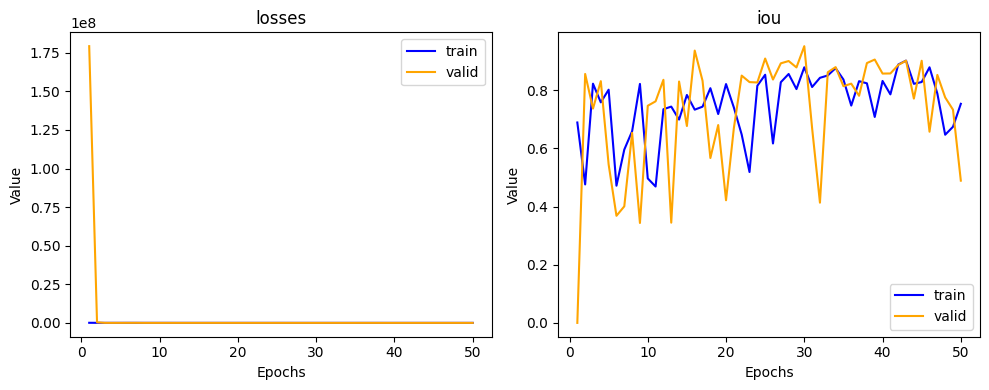

In [97]:
trainer.plot_metrics()

In [98]:
segnet_model_focal = trainer.model

In [99]:
test(segnet_model_focal, test_dataloader)

tensor(0.7754, device='cuda:0')

Итого у нас лучше всего модель учится на bce loss при одинаковых параметрах обучения: 
- BCE: 0.7925
- Dice: 0.7580
- Focal: 0.7754
Выходит, что опытный старичок обогнал все остальные функции потерь. Обучение на всех, кроме dice, было +- стабильное (по метрике iou). Также по непонятным мне причинам в focal были огромные потери, но модель все равно нормально обучилась.

Я заметил, что обучение на bce было быстрее и модель была более стабильна. Сошлась бы быстрее, если бы я не убрал early stopping. Но честно говоря данных настолько мало, что тут уж не приходится говорить о каком то запредельном качестве

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

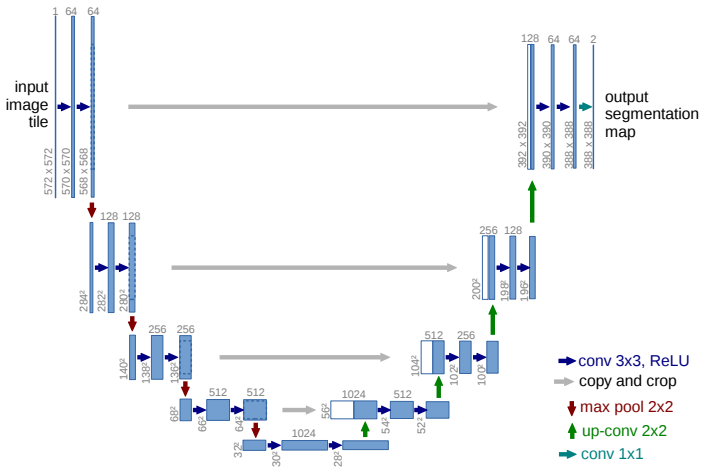

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [46]:
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import JaccardIndex
import torch.optim as optim

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

Погуглил и нашел реализованную архитектуру. Надо просто скачать ее. Умный в гору не пойдет, умный гору обойдет)

## Обучите UNet ()

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



#### Dice

In [39]:
import torch.optim as optim

In [52]:
import torch
model_unet_dice = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=64, pretrained=False).to(device)

Using cache found in C:\Users\ASUS/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [42]:
loss_fn = dice_loss
optimizer = optim.Adam(model_unet_dice.parameters(), lr=3e-3)

In [46]:
trainer = Trainer(model=model_unet_dice,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=8,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 0.509,  Valid Losses: 0.356,  Train Iou: 0.423,  Valid Iou: 0.0 - Time: 5.43s


Epoch 2/50 - Train Losses: 0.487,  Valid Losses: 0.34,  Train Iou: 0.843,  Valid Iou: 0.053 - Time: 4.38s


Epoch 3/50 - Train Losses: 0.483,  Valid Losses: 0.296,  Train Iou: 0.645,  Valid Iou: 0.458 - Time: 4.38s


Epoch 4/50 - Train Losses: 0.484,  Valid Losses: 0.295,  Train Iou: 0.529,  Valid Iou: 0.756 - Time: 4.39s


Epoch 5/50 - Train Losses: 0.489,  Valid Losses: 0.302,  Train Iou: 0.585,  Valid Iou: 0.494 - Time: 4.40s


Epoch 6/50 - Train Losses: 0.481,  Valid Losses: 0.303,  Train Iou: 0.806,  Valid Iou: 0.724 - Time: 4.39s


Epoch 7/50 - Train Losses: 0.475,  Valid Losses: 0.295,  Train Iou: 0.829,  Valid Iou: 0.909 - Time: 4.39s


Epoch 8/50 - Train Losses: 0.468,  Valid Losses: 0.296,  Train Iou: 0.861,  Valid Iou: 0.714 - Time: 4.40s


Epoch 9/50 - Train Losses: 0.467,  Valid Losses: 0.306,  Train Iou: 0.805,  Valid Iou: 0.602 - Time: 4.40s


Epoch 10/50 - Train Losses: 0.471,  Valid Losses: 0.289,  Train Iou: 0.851,  Valid Iou: 0.899 - Time: 4.40s


Epoch 11/50 - Train Losses: 0.475,  Valid Losses: 0.301,  Train Iou: 0.78,  Valid Iou: 0.482 - Time: 4.40s


Epoch 12/50 - Train Losses: 0.466,  Valid Losses: 0.296,  Train Iou: 0.691,  Valid Iou: 0.812 - Time: 4.41s


Epoch 13/50 - Train Losses: 0.47,  Valid Losses: 0.299,  Train Iou: 0.733,  Valid Iou: 0.877 - Time: 4.40s


Epoch 14/50 - Train Losses: 0.471,  Valid Losses: 0.305,  Train Iou: 0.758,  Valid Iou: 0.821 - Time: 4.40s


Epoch 15/50 - Train Losses: 0.483,  Valid Losses: 0.294,  Train Iou: 0.496,  Valid Iou: 0.877 - Time: 4.41s


Epoch 16/50 - Train Losses: 0.476,  Valid Losses: 0.31,  Train Iou: 0.694,  Valid Iou: 0.76 - Time: 4.41s


Epoch 17/50 - Train Losses: 0.466,  Valid Losses: 0.291,  Train Iou: 0.808,  Valid Iou: 0.586 - Time: 4.41s


Epoch 18/50 - Train Losses: 0.475,  Valid Losses: 0.287,  Train Iou: 0.599,  Valid Iou: 0.884 - Time: 4.41s


Epoch 19/50 - Train Losses: 0.477,  Valid Losses: 0.307,  Train Iou: 0.695,  Valid Iou: 0.861 - Time: 4.41s


Epoch 20/50 - Train Losses: 0.473,  Valid Losses: 0.284,  Train Iou: 0.753,  Valid Iou: 0.858 - Time: 4.41s


Epoch 21/50 - Train Losses: 0.468,  Valid Losses: 0.312,  Train Iou: 0.92,  Valid Iou: 0.182 - Time: 4.41s


Epoch 22/50 - Train Losses: 0.473,  Valid Losses: 0.291,  Train Iou: 0.682,  Valid Iou: 0.535 - Time: 4.41s


Epoch 23/50 - Train Losses: 0.466,  Valid Losses: 0.298,  Train Iou: 0.897,  Valid Iou: 0.911 - Time: 4.42s


Epoch 24/50 - Train Losses: 0.464,  Valid Losses: 0.282,  Train Iou: 0.766,  Valid Iou: 0.898 - Time: 4.41s


Epoch 25/50 - Train Losses: 0.471,  Valid Losses: 0.281,  Train Iou: 0.763,  Valid Iou: 0.783 - Time: 4.42s


Epoch 26/50 - Train Losses: 0.459,  Valid Losses: 0.287,  Train Iou: 0.897,  Valid Iou: 0.916 - Time: 4.42s


Epoch 27/50 - Train Losses: 0.468,  Valid Losses: 0.309,  Train Iou: 0.837,  Valid Iou: 0.736 - Time: 4.42s


Epoch 28/50 - Train Losses: 0.465,  Valid Losses: 0.287,  Train Iou: 0.932,  Valid Iou: 0.781 - Time: 4.42s


Epoch 29/50 - Train Losses: 0.475,  Valid Losses: 0.298,  Train Iou: 0.808,  Valid Iou: 0.85 - Time: 4.42s


Epoch 30/50 - Train Losses: 0.469,  Valid Losses: 0.29,  Train Iou: 0.909,  Valid Iou: 0.798 - Time: 4.42s


Epoch 31/50 - Train Losses: 0.461,  Valid Losses: 0.307,  Train Iou: 0.72,  Valid Iou: 0.797 - Time: 4.43s


Epoch 32/50 - Train Losses: 0.472,  Valid Losses: 0.302,  Train Iou: 0.718,  Valid Iou: 0.868 - Time: 4.42s



Early stopping triggered after 33 epochs


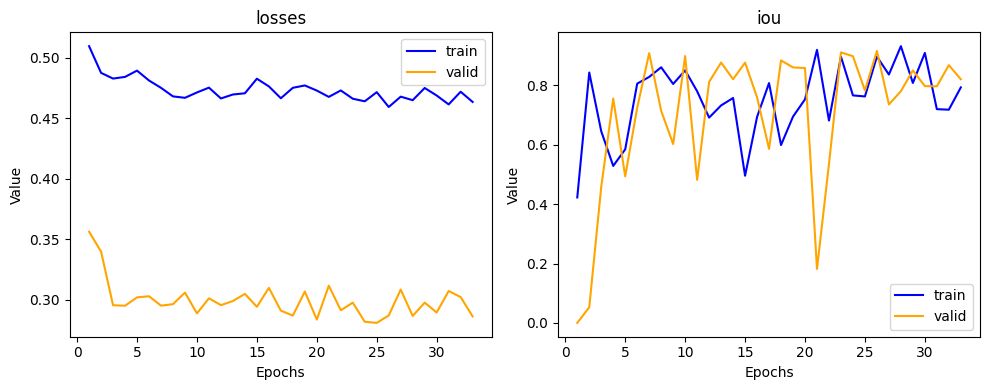

In [47]:
trainer.plot_metrics()

In [48]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)

In [49]:
test(model_unet_dice, test_dataloader)

tensor(0.7527, device='cuda:0')

#### Focal

In [52]:
import torch
model_unet_focal = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=64, pretrained=False).to(device)

Using cache found in C:\Users\ASUS/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [53]:
loss_fn = focal_loss
optimizer = optim.Adam(model_unet_focal.parameters(), lr=3e-3)

In [54]:
trainer = Trainer(model=model_unet_focal,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=8,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 97764.383,  Valid Losses: 50651.305,  Train Iou: 0.583,  Valid Iou: 0.113 - Time: 4.75s


Epoch 2/50 - Train Losses: 78037.94,  Valid Losses: 122975.049,  Train Iou: 0.488,  Valid Iou: 0.106 - Time: 4.40s


Epoch 3/50 - Train Losses: 77253.709,  Valid Losses: 42080.465,  Train Iou: 0.517,  Valid Iou: 0.453 - Time: 4.45s


Epoch 4/50 - Train Losses: 73601.056,  Valid Losses: 46615.746,  Train Iou: 0.819,  Valid Iou: 0.652 - Time: 4.46s


Epoch 5/50 - Train Losses: 72757.579,  Valid Losses: 37825.188,  Train Iou: 0.807,  Valid Iou: 0.738 - Time: 4.43s


Epoch 6/50 - Train Losses: 71444.813,  Valid Losses: 38006.851,  Train Iou: 0.699,  Valid Iou: 0.76 - Time: 4.42s


Epoch 7/50 - Train Losses: 71350.913,  Valid Losses: 44861.381,  Train Iou: 0.78,  Valid Iou: 0.807 - Time: 4.41s


Epoch 8/50 - Train Losses: 72838.618,  Valid Losses: 38563.032,  Train Iou: 0.523,  Valid Iou: 0.442 - Time: 4.41s


Epoch 9/50 - Train Losses: 69794.41,  Valid Losses: 38491.766,  Train Iou: 0.743,  Valid Iou: 0.787 - Time: 4.42s


Epoch 10/50 - Train Losses: 69404.786,  Valid Losses: 37138.798,  Train Iou: 0.674,  Valid Iou: 0.761 - Time: 4.51s


Epoch 11/50 - Train Losses: 69836.721,  Valid Losses: 41511.12,  Train Iou: 0.572,  Valid Iou: 0.653 - Time: 4.55s


Epoch 12/50 - Train Losses: 71237.889,  Valid Losses: 43445.389,  Train Iou: 0.561,  Valid Iou: 0.921 - Time: 4.48s


Epoch 13/50 - Train Losses: 69605.877,  Valid Losses: 40452.287,  Train Iou: 0.798,  Valid Iou: 0.9 - Time: 4.41s


Epoch 14/50 - Train Losses: 70317.021,  Valid Losses: 44920.648,  Train Iou: 0.725,  Valid Iou: 0.832 - Time: 4.43s


Epoch 15/50 - Train Losses: 69477.476,  Valid Losses: 36965.183,  Train Iou: 0.84,  Valid Iou: 0.713 - Time: 4.53s


Epoch 16/50 - Train Losses: 69509.87,  Valid Losses: 38613.547,  Train Iou: 0.834,  Valid Iou: 0.75 - Time: 4.58s


Epoch 17/50 - Train Losses: 68042.914,  Valid Losses: 38348.933,  Train Iou: 0.487,  Valid Iou: 0.68 - Time: 4.39s


Epoch 18/50 - Train Losses: 70239.983,  Valid Losses: 36890.039,  Train Iou: 0.764,  Valid Iou: 0.811 - Time: 4.38s


Epoch 19/50 - Train Losses: 68890.696,  Valid Losses: 37616.404,  Train Iou: 0.64,  Valid Iou: 0.745 - Time: 4.38s


Epoch 20/50 - Train Losses: 70035.534,  Valid Losses: 37308.359,  Train Iou: 0.925,  Valid Iou: 0.743 - Time: 4.38s


Epoch 21/50 - Train Losses: 69704.382,  Valid Losses: 36842.799,  Train Iou: 0.877,  Valid Iou: 0.504 - Time: 4.39s


Epoch 22/50 - Train Losses: 69201.602,  Valid Losses: 38062.35,  Train Iou: 0.852,  Valid Iou: 0.863 - Time: 4.52s


Epoch 23/50 - Train Losses: 68616.282,  Valid Losses: 37850.595,  Train Iou: 0.906,  Valid Iou: 0.91 - Time: 4.45s


Epoch 24/50 - Train Losses: 68758.646,  Valid Losses: 37320.984,  Train Iou: 0.692,  Valid Iou: 0.781 - Time: 4.56s


Epoch 25/50 - Train Losses: 68979.3,  Valid Losses: 38470.825,  Train Iou: 0.902,  Valid Iou: 0.926 - Time: 4.54s


Epoch 26/50 - Train Losses: 69976.939,  Valid Losses: 38921.964,  Train Iou: 0.561,  Valid Iou: 0.777 - Time: 4.52s


Epoch 27/50 - Train Losses: 68920.723,  Valid Losses: 36744.695,  Train Iou: 0.75,  Valid Iou: 0.425 - Time: 4.38s


Epoch 28/50 - Train Losses: 68259.797,  Valid Losses: 37342.024,  Train Iou: 0.823,  Valid Iou: 0.498 - Time: 4.56s


Epoch 29/50 - Train Losses: 68755.656,  Valid Losses: 37512.658,  Train Iou: 0.832,  Valid Iou: 0.371 - Time: 4.45s


Epoch 30/50 - Train Losses: 68677.3,  Valid Losses: 37002.557,  Train Iou: 0.817,  Valid Iou: 0.741 - Time: 4.58s


Epoch 31/50 - Train Losses: 70151.949,  Valid Losses: 36639.067,  Train Iou: 0.75,  Valid Iou: 0.832 - Time: 4.48s


Epoch 32/50 - Train Losses: 67869.642,  Valid Losses: 36889.33,  Train Iou: 0.57,  Valid Iou: 0.736 - Time: 4.38s


Epoch 33/50 - Train Losses: 68361.148,  Valid Losses: 37900.766,  Train Iou: 0.825,  Valid Iou: 0.812 - Time: 4.39s


Epoch 34/50 - Train Losses: 67509.631,  Valid Losses: 38403.536,  Train Iou: 0.771,  Valid Iou: 0.49 - Time: 4.38s


Epoch 35/50 - Train Losses: 69117.034,  Valid Losses: 36919.28,  Train Iou: 0.776,  Valid Iou: 0.881 - Time: 4.39s


Epoch 36/50 - Train Losses: 68717.043,  Valid Losses: 36939.666,  Train Iou: 0.648,  Valid Iou: 0.805 - Time: 4.41s


Epoch 37/50 - Train Losses: 68382.511,  Valid Losses: 37945.627,  Train Iou: 0.859,  Valid Iou: 0.887 - Time: 4.38s


Epoch 38/50 - Train Losses: 68420.623,  Valid Losses: 37629.759,  Train Iou: 0.7,  Valid Iou: 0.417 - Time: 4.39s



Early stopping triggered after 39 epochs


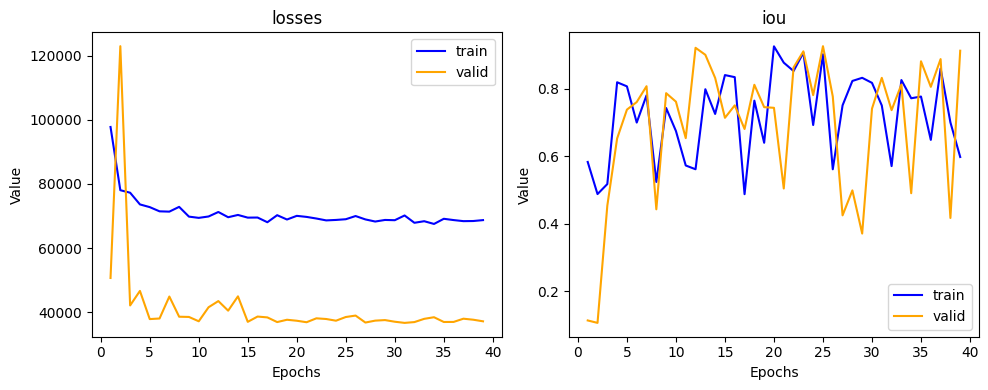

In [55]:
trainer.plot_metrics()

In [56]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)

In [57]:
test(model_unet_focal, test_dataloader)

tensor(0.7511, device='cuda:0')

#### BCE

In [58]:
import torch
model_unet_bce = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=64, pretrained=False).to(device)

Using cache found in C:\Users\ASUS/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [60]:
import torch.nn as nn

In [61]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet_bce.parameters(), lr=3e-3)

In [62]:
trainer = Trainer(model=model_unet_bce,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=8,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 0.702,  Valid Losses: 0.565,  Train Iou: 0.697,  Valid Iou: 0.168 - Time: 4.78s


Epoch 2/50 - Train Losses: 0.646,  Valid Losses: 0.354,  Train Iou: 0.835,  Valid Iou: 0.468 - Time: 4.40s


Epoch 3/50 - Train Losses: 0.622,  Valid Losses: 0.359,  Train Iou: 0.799,  Valid Iou: 0.346 - Time: 4.40s


Epoch 4/50 - Train Losses: 0.609,  Valid Losses: 0.352,  Train Iou: 0.713,  Valid Iou: 0.784 - Time: 4.41s


Epoch 5/50 - Train Losses: 0.604,  Valid Losses: 0.335,  Train Iou: 0.797,  Valid Iou: 0.841 - Time: 4.40s


Epoch 6/50 - Train Losses: 0.607,  Valid Losses: 0.335,  Train Iou: 0.804,  Valid Iou: 0.731 - Time: 4.41s


Epoch 7/50 - Train Losses: 0.601,  Valid Losses: 0.346,  Train Iou: 0.729,  Valid Iou: 0.896 - Time: 4.42s


Epoch 8/50 - Train Losses: 0.605,  Valid Losses: 0.344,  Train Iou: 0.568,  Valid Iou: 0.889 - Time: 4.43s


Epoch 9/50 - Train Losses: 0.603,  Valid Losses: 0.329,  Train Iou: 0.647,  Valid Iou: 0.964 - Time: 4.47s


Epoch 10/50 - Train Losses: 0.607,  Valid Losses: 0.351,  Train Iou: 0.701,  Valid Iou: 0.892 - Time: 4.57s


Epoch 11/50 - Train Losses: 0.596,  Valid Losses: 0.354,  Train Iou: 0.726,  Valid Iou: 0.92 - Time: 4.44s


Epoch 12/50 - Train Losses: 0.605,  Valid Losses: 0.346,  Train Iou: 0.69,  Valid Iou: 0.878 - Time: 4.42s


Epoch 13/50 - Train Losses: 0.603,  Valid Losses: 0.347,  Train Iou: 0.772,  Valid Iou: 0.802 - Time: 4.41s


Epoch 14/50 - Train Losses: 0.602,  Valid Losses: 0.339,  Train Iou: 0.839,  Valid Iou: 0.79 - Time: 4.41s


Epoch 15/50 - Train Losses: 0.594,  Valid Losses: 0.349,  Train Iou: 0.843,  Valid Iou: 0.389 - Time: 4.40s


Epoch 16/50 - Train Losses: 0.591,  Valid Losses: 0.339,  Train Iou: 0.778,  Valid Iou: 0.588 - Time: 4.41s



Early stopping triggered after 17 epochs


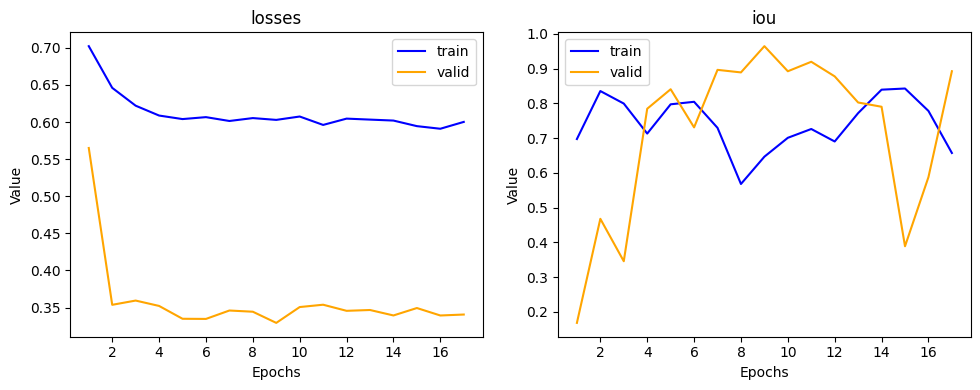

In [63]:
trainer.plot_metrics()

In [64]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)

In [65]:
test(model_unet_bce, test_dataloader)

tensor(0.7616, device='cuda:0')

#### Просто для примера обучу более легкую вариацию Unet

In [74]:
import torch
model_unet_small_bce = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=8, pretrained=False).to(device)

Using cache found in C:\Users\ASUS/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [75]:
import torch.nn as nn

In [76]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet_small_bce.parameters(), lr=3e-3)

In [77]:
trainer = Trainer(model=model_unet_small_bce,
                  train_loader=train_dataloader,
                  test_loader=valid_dataloader,
                  criterion=loss_fn,
                  optimizer=optimizer,
                  device=device,
                  epochs=50,
                  mode='segmentation',
                  jacard=iou_score,
                  patience=8,
                  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
                  )
trainer.train_model()

Epoch 1/50 - Train Losses: 0.729,  Valid Losses: 0.421,  Train Iou: 0.61,  Valid Iou: 0.465 - Time: 0.77s


Epoch 2/50 - Train Losses: 0.701,  Valid Losses: 0.385,  Train Iou: 0.495,  Valid Iou: 0.573 - Time: 0.37s


Epoch 3/50 - Train Losses: 0.672,  Valid Losses: 0.381,  Train Iou: 0.85,  Valid Iou: 0.816 - Time: 0.37s


Epoch 4/50 - Train Losses: 0.661,  Valid Losses: 0.381,  Train Iou: 0.759,  Valid Iou: 0.516 - Time: 0.37s


Epoch 5/50 - Train Losses: 0.648,  Valid Losses: 0.363,  Train Iou: 0.678,  Valid Iou: 0.846 - Time: 0.37s


Epoch 6/50 - Train Losses: 0.643,  Valid Losses: 0.366,  Train Iou: 0.763,  Valid Iou: 0.823 - Time: 0.39s


Epoch 7/50 - Train Losses: 0.639,  Valid Losses: 0.357,  Train Iou: 0.735,  Valid Iou: 0.896 - Time: 0.38s


Epoch 8/50 - Train Losses: 0.631,  Valid Losses: 0.352,  Train Iou: 0.836,  Valid Iou: 0.786 - Time: 0.37s


Epoch 9/50 - Train Losses: 0.623,  Valid Losses: 0.358,  Train Iou: 0.635,  Valid Iou: 0.904 - Time: 0.37s


Epoch 10/50 - Train Losses: 0.626,  Valid Losses: 0.35,  Train Iou: 0.532,  Valid Iou: 0.88 - Time: 0.37s


Epoch 11/50 - Train Losses: 0.62,  Valid Losses: 0.358,  Train Iou: 0.772,  Valid Iou: 0.828 - Time: 0.37s


Epoch 12/50 - Train Losses: 0.615,  Valid Losses: 0.347,  Train Iou: 0.833,  Valid Iou: 0.806 - Time: 0.38s


Epoch 13/50 - Train Losses: 0.614,  Valid Losses: 0.345,  Train Iou: 0.771,  Valid Iou: 0.841 - Time: 0.37s


Epoch 14/50 - Train Losses: 0.613,  Valid Losses: 0.348,  Train Iou: 0.685,  Valid Iou: 0.899 - Time: 0.37s


Epoch 15/50 - Train Losses: 0.614,  Valid Losses: 0.341,  Train Iou: 0.656,  Valid Iou: 0.857 - Time: 0.37s


Epoch 16/50 - Train Losses: 0.608,  Valid Losses: 0.357,  Train Iou: 0.878,  Valid Iou: 0.331 - Time: 0.37s


Epoch 17/50 - Train Losses: 0.608,  Valid Losses: 0.349,  Train Iou: 0.848,  Valid Iou: 0.923 - Time: 0.37s


Epoch 18/50 - Train Losses: 0.615,  Valid Losses: 0.354,  Train Iou: 0.802,  Valid Iou: 0.406 - Time: 0.37s


Epoch 19/50 - Train Losses: 0.607,  Valid Losses: 0.34,  Train Iou: 0.795,  Valid Iou: 0.907 - Time: 0.37s


Epoch 20/50 - Train Losses: 0.608,  Valid Losses: 0.342,  Train Iou: 0.856,  Valid Iou: 0.869 - Time: 0.37s


Epoch 21/50 - Train Losses: 0.606,  Valid Losses: 0.345,  Train Iou: 0.841,  Valid Iou: 0.74 - Time: 0.37s


Epoch 22/50 - Train Losses: 0.61,  Valid Losses: 0.346,  Train Iou: 0.686,  Valid Iou: 0.919 - Time: 0.37s


Epoch 23/50 - Train Losses: 0.606,  Valid Losses: 0.346,  Train Iou: 0.848,  Valid Iou: 0.895 - Time: 0.37s


Epoch 24/50 - Train Losses: 0.604,  Valid Losses: 0.342,  Train Iou: 0.715,  Valid Iou: 0.765 - Time: 0.37s


Epoch 25/50 - Train Losses: 0.605,  Valid Losses: 0.346,  Train Iou: 0.845,  Valid Iou: 0.533 - Time: 0.37s


Epoch 26/50 - Train Losses: 0.602,  Valid Losses: 0.337,  Train Iou: 0.808,  Valid Iou: 0.859 - Time: 0.37s


Epoch 27/50 - Train Losses: 0.603,  Valid Losses: 0.342,  Train Iou: 0.854,  Valid Iou: 0.846 - Time: 0.37s


Epoch 28/50 - Train Losses: 0.605,  Valid Losses: 0.342,  Train Iou: 0.894,  Valid Iou: 0.817 - Time: 0.37s


Epoch 29/50 - Train Losses: 0.603,  Valid Losses: 0.337,  Train Iou: 0.798,  Valid Iou: 0.802 - Time: 0.37s


Epoch 30/50 - Train Losses: 0.607,  Valid Losses: 0.347,  Train Iou: 0.629,  Valid Iou: 0.58 - Time: 0.37s


Epoch 31/50 - Train Losses: 0.606,  Valid Losses: 0.343,  Train Iou: 0.786,  Valid Iou: 0.795 - Time: 0.37s


Epoch 32/50 - Train Losses: 0.607,  Valid Losses: 0.338,  Train Iou: 0.861,  Valid Iou: 0.863 - Time: 0.39s


Epoch 33/50 - Train Losses: 0.605,  Valid Losses: 0.338,  Train Iou: 0.842,  Valid Iou: 0.582 - Time: 0.38s


Epoch 34/50 - Train Losses: 0.6,  Valid Losses: 0.334,  Train Iou: 0.685,  Valid Iou: 0.639 - Time: 0.38s


Epoch 35/50 - Train Losses: 0.601,  Valid Losses: 0.342,  Train Iou: 0.898,  Valid Iou: 0.832 - Time: 0.37s


Epoch 36/50 - Train Losses: 0.602,  Valid Losses: 0.338,  Train Iou: 0.888,  Valid Iou: 0.78 - Time: 0.37s


Epoch 37/50 - Train Losses: 0.597,  Valid Losses: 0.333,  Train Iou: 0.837,  Valid Iou: 0.956 - Time: 0.38s


Epoch 38/50 - Train Losses: 0.601,  Valid Losses: 0.338,  Train Iou: 0.898,  Valid Iou: 0.906 - Time: 0.38s


Epoch 39/50 - Train Losses: 0.602,  Valid Losses: 0.34,  Train Iou: 0.702,  Valid Iou: 0.886 - Time: 0.37s


Epoch 40/50 - Train Losses: 0.603,  Valid Losses: 0.342,  Train Iou: 0.788,  Valid Iou: 0.772 - Time: 0.39s


Epoch 41/50 - Train Losses: 0.6,  Valid Losses: 0.338,  Train Iou: 0.785,  Valid Iou: 0.578 - Time: 0.38s


Epoch 42/50 - Train Losses: 0.602,  Valid Losses: 0.338,  Train Iou: 0.906,  Valid Iou: 0.791 - Time: 0.38s


Epoch 43/50 - Train Losses: 0.6,  Valid Losses: 0.342,  Train Iou: 0.86,  Valid Iou: 0.784 - Time: 0.39s


Epoch 44/50 - Train Losses: 0.599,  Valid Losses: 0.34,  Train Iou: 0.745,  Valid Iou: 0.861 - Time: 0.39s



Early stopping triggered after 45 epochs


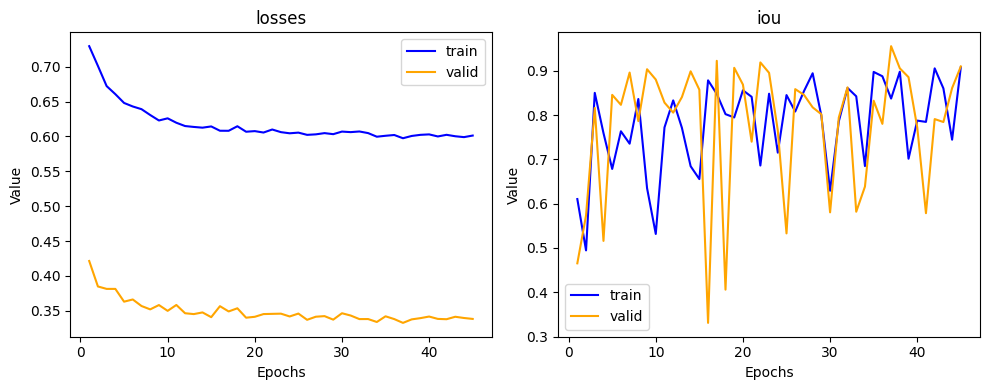

In [78]:
trainer.plot_metrics()

In [79]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)

In [80]:
test(model_unet_small_bce, test_dataloader)

tensor(0.8409, device='cuda:0')

### Итого:

Сначала хотелось бы сказать, что зря нам дали такую тяжелую архитектуру для простой задачи на крошечном датасете. Последняя нейронка, которая примерно в 8 раз легче первой, еще и справилась намного лучше (прирост 10% по iou). Так что не всегда глубина и большое количество параметров означает качество.

- и вот как раз обученная для примера нейронка дала лучший результат. Но если брать среди предполагаемых, то это SegNet со своим 0.78 iou. 
- лучшие лоссы получились на SegNet на лоссе Dice
- самая быстрая по обучению модель, как ни странно, легкая Unet). Остальные учатся примерно одинаково, тк имеют схожее число параметров
- SegNet показала себя лучше в одном забеге, однако Unet более стабилен. на всех лоссах показал достойные значения, которые в среднем выше сегнетовских